In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml
from sentinelhub import DataSource
import scipy.sparse as sparse
import scipy
from scipy.sparse.linalg import splu
from skimage.transform import resize
from sentinelhub import CustomUrlParam
from time import time as timer
import multiprocessing

/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py
#!source ~/.bash_profile

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [3]:
dates = ('2018-12-15', '2020-01-15')
SIZE = 9
IMSIZE = (SIZE * 14)+2

cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

# Helper functions (to be moved to a utils file)

In [4]:
EPSG = CRS.WGS84
GRID_SIZE_X = 1
GRID_SIZE_Y = 1

IMAGE_X = 14*GRID_SIZE_X
IMAGE_Y = 14*GRID_SIZE_Y

TEST_X = 5
TEST_Y = 5

with open("../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']

In [5]:
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    #@valid
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -54 <= tl[0] <= -48:
        epsg = 32622 if tl[1] > 0 else 32722
    if -60 <= tl[0] <= -54:
        epsg = 32621 if tl[1] > 0 else 32721
    if -66 <= tl[0] <= -60:
        epsg = 32620 if tl[1] > 0 else 32720
    if -72 <= tl[0] <= -66:
        epsg = 32619 if tl[1] > 0 else 32719
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    return [(min_x, min_y), (max_x, max_y)]
 

# Data download

In [6]:
def identify_clouds(bbox, epsg = EPSG, dates = dates):
    try:
        box = BBox(bbox, crs = epsg)
        cloud_request = WmsRequest(
            layer='CLOUD_DETECTION',
            bbox=box,
            time=dates,
            width=(SIZE*14)+2,
            height=(SIZE*14)+2,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.75,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        cloud_img = cloud_request.get_data()
        cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
        means = np.mean(cloud_probs, (1, 2))
        clean_steps = [i for i, val in enumerate(means) if val < 0.20]
        return clean_steps, means, cloud_probs
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
    
def download_dem(bbox, epsg = EPSG):
    #@valid
    box = BBox(bbox, crs = epsg)
    dem_s = (SIZE*14)+4
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=dem_s,
                         height=dem_s,
                         instance_id=API_KEY,
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    dem_image = calcSlope(dem_image.reshape((1, dem_s, dem_s)),
                  np.full((dem_s, dem_s), 10), np.full((dem_s, dem_s), 10), zScale = 1, minSlope = 0.02)
    dem_image = dem_image.reshape((dem_s,dem_s, 1))
    dem_image = dem_image[1:dem_s-1, 1:dem_s-1, :]
    return dem_image #/ np.max(dem_image)

def download_layer(bbox, epsg = EPSG, dates = dates):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box,
                time=dates,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        img_20 = np.stack(img_bands)
        print("Original size: {}".format(img_20.shape))
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box,
                time=dates,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=24),
        )
        
        img_bands = image_request.get_data()
        img_10 = np.stack(img_bands)
        print("Original 10 size: {}".format(img_10.shape))
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        shadows = img_10[:, :, :, -1]
        img_10 = img_10[:, :, :, :-1]
        
        shadows[np.where(shadows != 3)] = 0
        shadows[np.where(shadows == 3)] = 1
        print("Data shape: {}".format(shadows.shape))
        shadow_sum = np.sum(shadows, axis = (1, 2))
        shadow_steps = np.argwhere(shadow_sum > (IMSIZE*IMSIZE) / 4)
        
        img = np.concatenate([img_10, img_20], axis = -1)
        return img, image_request, shadows, shadow_steps

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Cloud and shadow removal

In [7]:
def remove_cloud_and_shadows(tiles, c_probs, shadows, image_dates):
    wsize = 5
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, (c_probs.shape[0], 16, 8, 16, 8))
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], IMSIZE, IMSIZE), 0)
    c_probs[np.where(c_probs < 6)] = 0
    c_probs[np.where(c_probs >= 6)] = 1
    secondary_c_probs = np.copy(c_probs)
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    number_interpolated = 0
    for cval in range(0, IMSIZE - 4, 1):
        for rval in range(0, IMSIZE - 4, 1):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            sums = np.sum(subs, axis = (1, 2))
            satisfactory = [x for x in range(c_probs.shape[0]) if sums[x] < 10]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 10:
                    number_interpolated += 1
                    before, after = calculate_proximal_steps(date, satisfactory)
                    before = date + before
                    after = date + after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate 
    print("A total of {} pixels were interpolated".format(number_interpolated))
    return tiles, c_probs, secondary_c_probs

def remove_missed_clouds(img):
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 20)
    return to_remove

def threshold_shadows(arr):
    arr = np.copy(arr)
    iqr = np.percentile(arr.flatten(), 75) - np.percentile(arr.flatten(), 25)
    low = np.percentile(arr.flatten(), 25)
    #high = np.percentile(arr.flatten(), 75)
    thresh_low = low - 1.5*iqr
    #thresh_high = high + 2*iqr
    #arr[np.where(arr > thresh_high)] = 1.
    arr[np.where(arr < thresh_low)] = 1.
    arr[np.where(arr < 1)] = 0.
    arr = np.reshape(arr, (arr.shape[0], 16, 8, 16, 8))
    arr = np.sum(arr, axis = (2, 4))
    arr = resize(arr, (arr.shape[0], 128, 128), 0)
    fake_shadows = np.zeros((arr.shape[0], arr.shape[1], arr.shape[2]))
    for step in range(arr.shape[0]):
        if step > 0:
            for x in range(arr.shape[1]):
                for y in range(arr.shape[2]):
                    if arr[step, x, y] > 0:
                        before = arr[step - 1, x, y]
                        if abs(before - arr[step, x, y]) <= 20:
                            fake_shadows[step, x, y] = 1
                            
    for step in range(arr.shape[0]):
        if step < arr.shape[0] - 1:
            for x in range(arr.shape[1]):
                for y in range(arr.shape[2]):
                    if arr[step, x, y] > 0:
                        after = arr[step + 1, x, y]
                        if abs(after - arr[step, x, y]) <= 20:
                            fake_shadows[step, x, y] = 1
    before = np.sum(arr)
    arr[np.where(fake_shadows == 1)] = 0.
    after = np.sum(arr)
    arr[np.where(arr > 9)] = 1.
    arr[np.where(arr < 9)] = 0.
    print("Removed {} fake shadows, leaving {}".format(before - after, after))
    print("The total percent shadow cover is: {}%".format(after/(arr.shape[0]*arr.shape[1]*arr.shape[2])))
    for step in range(arr.shape[0]):
        for x in range(1, arr.shape[1] -1):
            for y in range(1, arr.shape[2] - 1):
                if np.sum(arr[step, x-1:x+2, y-1:y+2]) == 1:
                    if arr[step, x, y] != 0:
                        print("Removing: {} {} {} {}".format(step, x, y, np.sum(arr[step, x-1:x+2, y-1:y+2])))
                        arr[step, x, y] = 0
    
    return arr

# Data interpolation

In [8]:
diagonals = np.zeros(2*2+1)
diagonals[2] = 1.
for i in range(2):
    diff = diagonals[:-1] - diagonals[1:]
    diagonals = diff
offsets = np.arange(2+1)
shape = (70, 72)

def smooth(y, lmbd = 800, diagonals = diagonals, offsets = offsets, shape = shape, d = 2):
    E = sparse.eye(72, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

def calculate_and_save_best_images(img_bands, image_dates):

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Identify the dates where there is < 20% cloud cover
    #satisfactory_ids = list(np.argwhere(np.array(means) < 4.).reshape(-1, )) 
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 8 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 8 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                            
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    keep_steps = []
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] * 0.5#info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]] * 0.5 #info['image_ratio'][1]
            step = step1 + step2
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps



In [33]:
coords

(29.952997, -1.515869)

# Tiling and coordinate selection functions

In [53]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.316919, 2.581680) # niger
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # weest mamprusi, ghana
#coords = (7.702058, -0.709011) # brong ahafo, bono east
#coords = (10.097017, -2.439068)# close to wa, has been done
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (7.398111, -1.269223) # cocoa
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (-20.147320, -40.837770) BR 2
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (6.167177, -75.693226) # medellin, colombia
#coords = (4.179529, -74.889171) # colombia
#coords = (6.518909, -0.826008) # kwahu large
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.757749, -90.004949) # elsalvador imposible
#coords = (13.727334, -90.015579) # elsalvador imposible2
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (-36.431237, -71.872030) # Chile
coords = (12.398014, -86.963042) # Nicaragua
coords = (coords[1], coords[0])
OUTPUT_FOLDER = '../data/nicaragua/'
#13.567962754335872

borders = bounding_box(coords, 10*(SIZE*14), 10*(SIZE*14), expansion = 0)
print(borders)

[(-86.95144801283655, 12.409406504599893), (-86.963042, 12.398014000000002)]


[(-86.95135599311645, 12.409495093789172), (-86.96313401174123, 12.39792175578302)]
[(-86.93976361014562, 12.409494592697428), (-86.95154213849747, 12.397921759724845)]
[(-86.92817122974726, 12.409494091132904), (-86.93995026734096, 12.397921763670396)]
[(-86.91657885242067, 12.409493589095645), (-86.92835839877094, 12.397921767619666)]
[(-86.90498647866518, 12.409493086585682), (-86.9167665332867, 12.397921771572657)]
[(-86.89339410898003, 12.409492583603068), (-86.90517467138747, 12.397921775529374)]
[(-86.88180174386456, 12.409492080147839), (-86.89358281357251, 12.397921779489808)]
[(-86.87020938381805, 12.40949157622004), (-86.88199096034106, 12.397921783453967)]
[(-86.85861702933978, 12.409491071819716), (-86.87039911219239, 12.397921787421842)]
[(-86.84702468092908, 12.409490566946907), (-86.85880726962577, 12.397921791393445)]
[(-86.83543233908522, 12.409490061601652), (-86.84721543314043, 12.39792179536876)]
[(-86.82384000430751, 12.409489555783999), (-86.83562360323563, 12.39

[(-86.69623218713426, 12.489243917580833), (-86.70802499355189, 12.477681954198818)]
[(-86.68463643591524, 12.489243402781469), (-86.69642974491681, 12.477681958248581)]
[(-86.67304069827259, 12.489242887509995), (-86.68483450937154, 12.477681962302057)]
[(-86.95135190050686, 12.500649375792044), (-86.96313404393428, 12.489076129158908)]
[(-86.93974257485652, 12.500648870355935), (-86.95152523264159, 12.489076133134933)]
[(-86.92814614626239, 12.500648365007848), (-86.93992931734779, 12.48907613711027)]
[(-86.9165497207449, 12.500647859186694), (-86.92833340464486, 12.489076141089333)]
[(-86.90495329880413, 12.50064735289253), (-86.91673749503285, 12.48907614507212)]
[(-86.89335688094027, 12.500646846125383), (-86.90514158901188, 12.489076149058626)]
[(-86.88176046765344, 12.500646338885314), (-86.89354568708202, 12.489076153048865)]
[(-86.87016405944374, 12.50064583117235), (-86.88194978974336, 12.489076157042824)]
[(-86.85856765681133, 12.500645322986536), (-86.87035389749602, 12.489

[(-86.67292576748004, 12.580396539516961), (-86.68472382984291, 12.56883579837817)]
[(-86.95134777562173, 12.59180304212274), (-86.96313407638141, 12.580229887392278)]
[(-86.9397213732215, 12.591802532327208), (-86.95150819298941, 12.580229891402617)]
[(-86.92812086441873, 12.591802023192994), (-86.93990820155229, 12.580229895407765)]
[(-86.91652035869744, 12.591801513585398), (-86.92830821271035, 12.580229899416638)]
[(-86.90491985655865, 12.59180100350446), (-86.9167082269646, 12.580229903429242)]
[(-86.8933193585033, 12.591800492950224), (-86.90510824481592, 12.580229907445572)]
[(-86.88171886503238, 12.591799981922739), (-86.89350826676524, 12.580229911465624)]
[(-86.87011837664691, 12.591799470422028), (-86.88190829331357, 12.580229915489404)]
[(-86.8585178938478, 12.591798958448157), (-86.87030832496177, 12.580229919516908)]
[(-86.84691741713607, 12.591798446001166), (-86.85870836221079, 12.580229923548147)]
[(-86.83531694701271, 12.591797933081088), (-86.84710840556161, 12.58022

[(-86.85846773978975, 12.68295197401218), (-86.87026239398578, 12.671383058658101)]
[(-86.84686315085477, 12.682951457774205), (-86.85865832308012, 12.671383062719183)]
[(-86.83525856851901, 12.682950941062822), (-86.84705425828659, 12.67138306678399)]
[(-86.82365399328432, 12.682950423878076), (-86.83545020010699, 12.671383070852524)]
[(-86.81204942565253, 12.682949906220017), (-86.82384614904308, 12.671383074924787)]
[(-86.80044486612543, 12.682949388088684), (-86.81224210559665, 12.671383079000776)]
[(-86.78884031520485, 12.682948869484127), (-86.80063807026946, 12.671383083080492)]
[(-86.77723577339262, 12.68294835040638), (-86.7890340435633, 12.671383087163932)]
[(-86.76563124119056, 12.682947830855497), (-86.77743002597998, 12.6713830912511)]
[(-86.75402671910042, 12.68294731083152), (-86.76582601802119, 12.671383095341996)]
[(-86.74242220762412, 12.68294679033449), (-86.75422202018876, 12.671383099436612)]
[(-86.7308177072634, 12.682946269364457), (-86.74261803298447, 12.6713831

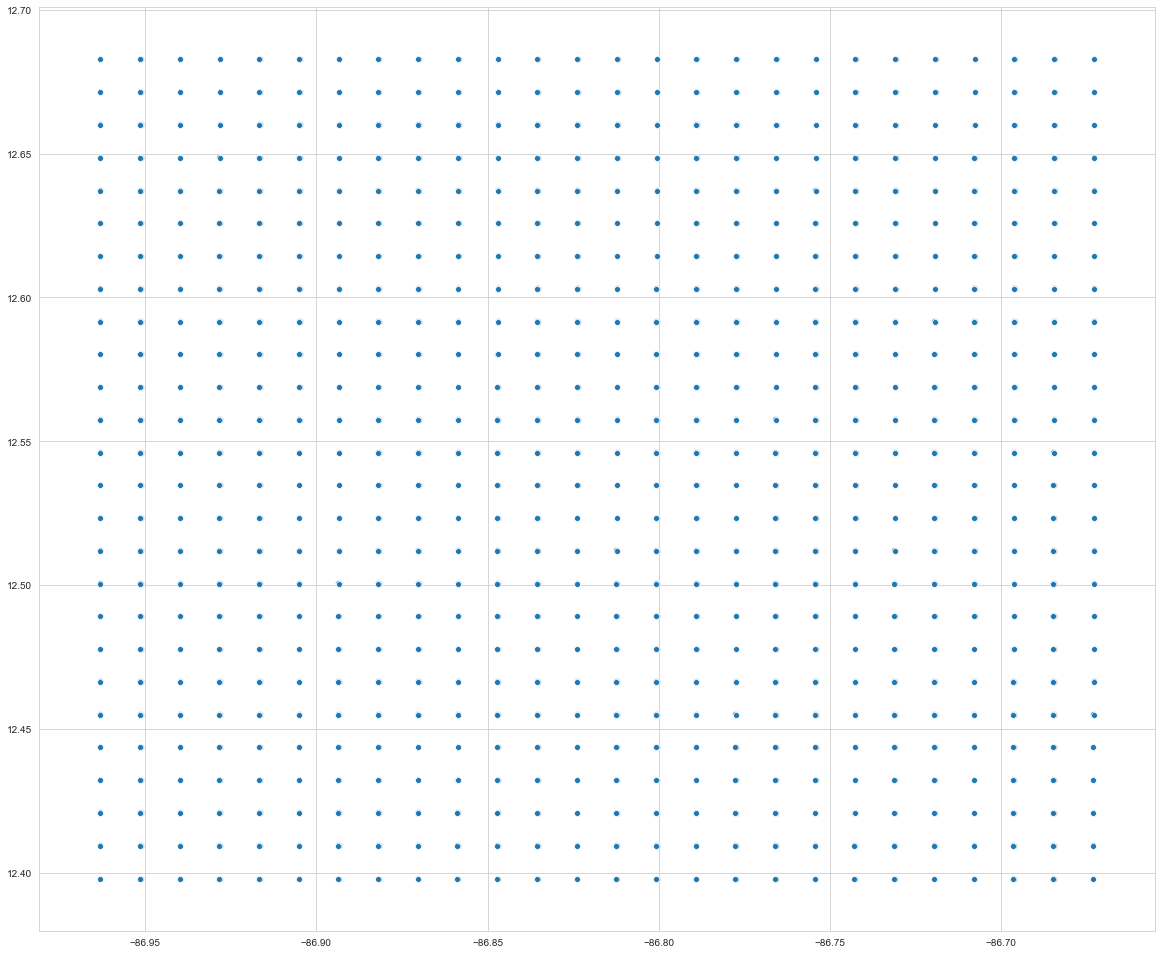

In [54]:
# this needs the first coordinate to not be [coords] for different y steps
def calculate_offset_coords(coords, x_step, y_step, number):
    offset_coords = []
    y_coord = bounding_box(coords, x_step, y_step, expansion = 0)
    y_coord = y_coord[0][1]
    for i in range(number):
        bbx = bounding_box(coords, (i+1)*x_step, y_step, expansion = 0)
        coord_x = bbx[0][0]
        coord_y = y_coord
        offset_coords.append((coord_x, coord_y))
    coords = [(coords[0], y_coord)]
    return coords + offset_coords

SIZE = 9
corner_coordinates = []
for row in range(0, 25):
    temp = calculate_offset_coords(coords, x_step = (SIZE*140), 
                                            y_step = row*(SIZE*140), 
                                            number = 25)
    corner_coordinates.append([[x, [y, row]] for x, y in zip(temp, [col for col in range(0, 25)])])

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(20, 17))

# So instead of corner coordinates, make the BBoxes to begin with and verify with a plot
# color each box differently

tiled_bbx = []
xs = []
ys =[]
for x in corner_coordinates:
    for y in x:
        bbx = bounding_box(y[0], SIZE*140, SIZE*140, 10)
        print(bbx)
        xs.append(bbx[0][0])
        xs.append(bbx[1][0])
        
        xs.append(bbx[0][0])
        xs.append(bbx[1][0])
        
        ys.append(bbx[0][1])
        ys.append(bbx[1][1])   
        ys.append(bbx[1][1])
        ys.append(bbx[0][1])
        
sns.scatterplot(x = xs, y = ys)

In [55]:
MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
print('Symbolic Model Created.')

model.load_weights(predict_file)

def DSen2(d10, d20):
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

Symbolic Model Created.


In [56]:
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)

In [57]:
def check_outliers(sample):
    for date in range(24):
        for band in range(10):
            maxs = np.max(sample[date, :, :, band])
            mins = np.min(sample[date, :, :, band])
            if maxs == 1.0 or mins == 0.0:
                print("Found null outlier")
                return True
            if maxs == mins:
                print("Found missing outlier")
                return True
            if maxs >= 1.05 or mins <= -1.05:
                print("Found range outlier")
                return True
    else:
        return False
    
    
def tile_images(arr, output_folder):
    # Normal
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 126, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 126, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
            
def calculate_proximal_steps(date, satisfactory):
    arg_before = None
    arg_after = None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    #print(arg_before, date, arg_after)
    return arg_before, arg_after

def worker_download(coord, folder = OUTPUT_FOLDER, year = 2019):
    idx_x = coord[1][0]
    idx_y = coord[1][1]
    start = timer()
    print("Starting: {} {}".format(idx_x, idx_y))
    coord = coord[0]
    output_folder = OUTPUT_FOLDER + "{}".format(str(idx_y))
    if not os.path.exists(os.path.realpath(output_folder)):
        os.makedirs(os.path.realpath(output_folder))
    existing = [x for x in os.listdir(os.path.realpath(output_folder))]
    if str(idx_x) + ".npy" not in existing:
        tiled_bbx = bounding_box(coord, y_offset_max = (SIZE*140)-0, x_offset_max = (SIZE*140)+0, expansion = 10)
        dem_bbx = bounding_box(coord, y_offset_max = SIZE*140, x_offset_max = SIZE*140, expansion = 20)
        cloud_timer = timer()
        clean_steps, means, cloud_probs = identify_clouds(tiled_bbx)
        
        tiles, request, shadows, shadow_steps = download_layer(tiled_bbx)
        print("Downloaded imagery")
        cloud_end = timer()
        print("The imagery calcs and data take {}".format(cloud_end - cloud_timer))
        
        image_dates = []
        for date in request.get_dates():
            if date.year == year - 1:
                image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
            if date.year == year:
                image_dates.append(starting_days[(date.month-1)] + date.day)
            if date.year == year + 1:
                image_dates.append(365 + starting_days[(date.month-1)]+date.day)
        image_dates = np.array(image_dates)

        args = np.array([len(np.argwhere(cloud_probs[x, :, :].reshape((128)*(128)) > 0.3)) for x in range(cloud_probs.shape[0])])
        dirty_steps = np.argwhere(args > (128)*(128) / 4)
        missing_images = [np.argwhere(tiles[x, :, : :10].flatten() == 0.0) for x in range(tiles.shape[0])]
        missing_images = np.array([len(x) for x in missing_images])
        missing_images_p = [np.argwhere(tiles[x, :, : :10].flatten() >= 1) for x in range(tiles.shape[0])]
        missing_images_p = np.array([len(x) for x in missing_images_p])
        missing_images += missing_images_p
        missing_images = list(np.argwhere(missing_images >= 100))
        to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(shadow_steps)))

        # Remove null steps
        print("There are {}/{} dirty steps: {} cloud, {} missing, {} shadows".format(len(to_remove),
                                                                                    len(tiles), len(dirty_steps),
                                                                                    len(missing_images),
                                                                                    len(shadow_steps)))

        tiles = np.delete(tiles, to_remove, 0)
        cloud_probs = np.delete(cloud_probs, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        shadows = np.delete(shadows, to_remove, 0)
        #tiles = remove_blank_steps(tiles)
        
        to_remove = remove_missed_clouds(tiles)
        tiles = np.delete(tiles, to_remove, 0)
        cloud_probs = np.delete(cloud_probs, to_remove, 0)
        shadows = np.delete(shadows, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        print("Removing {} steps based on ratio".format(len(to_remove)))
        
        bef = timer()
        dem = download_dem(dem_bbx)
        dem = np.tile(dem[np.newaxis, :, :, :], (tiles.shape[0], 1, 1, 1))
        tiles = np.concatenate([tiles, dem], axis = -1)
        tiles[:, :, :, 10] /= 90
        aft = timer()
        print("The DEM calcs took {}".format(aft - bef))
        
        new_shadows = threshold_shadows(tiles[:, :, :, 3])
        x, new_probs, mid_probs = remove_cloud_and_shadows(tiles, cloud_probs, new_shadows, image_dates)
        bef = timer()
        print("Before super: {}".format(x.shape))

        d10 = x[:, :, :, 0:4]
        d20 = x[:, :, :, 4:10]

        d10 = np.swapaxes(d10, 1, -1)
        d10 = np.swapaxes(d10, 2, 3)
        d20 = np.swapaxes(d20, 1, -1)
        d20 = np.swapaxes(d20, 2, 3)
        superresolved = DSen2(d10, d20)
        superresolved = np.swapaxes(superresolved, 1, -1)
        superresolved = np.swapaxes(superresolved, 1, 2)

        # returns band IDXs 3, 4, 5, 7, 8, 9
        x[:, :, :, 4:10] = superresolved
        aft = timer()
        print("The superresolve took: {}".format(aft - bef))
        x, amin = evi(x, True)
        x = bi(x, True)
        x = msavi2(x, True)
        x = si(x, True)
        
        # check for and remove null values
        
        missing_pixels = 0
        for band in range(0, 15):
            for time in range(0, x.shape[0]):
                x_i = x[time, :, :, band]
                missing_pixels += len(np.argwhere(np.isnan(x_i)))
                x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
                x[time, :, :, band] = x_i
        print("There are {} missing pixels".format(missing_pixels))
        
        
        x = calculate_and_save_best_images(x, image_dates)
        
        bef = timer()
        no_dem = np.delete(x, 10, -1)
        no_dem = np.reshape(no_dem, (72, 128*128*14))
        no_dem = np.swapaxes(no_dem, 0, 1)
        
        pool = multiprocessing.Pool(6)
        no_dem = pool.map(smooth, no_dem)
        pool.close()
        pool.join()
        
        no_dem = np.swapaxes(no_dem, 0, 1)
        no_dem = np.reshape(no_dem, (72, 128, 128, 14))
        x[:, :, :, :10] = no_dem[:, :, :, :10]
        x[:, :, :, 11:] = no_dem[:, :, :, 10:]
        aft = timer()
        print("The interpolation of pixels took {}".format(aft - bef))
        
        #for row in range(0, (SIZE*14)+2):
        #    for column in range(0, (SIZE*14)+2):
        #        for band in [x for x in range(0, 15) if x != 10]:
        #            x[:, row, column, band] = smooth(x[:, row, column, band], 800, d = 2)
        
        biweekly_dates = np.array([day for day in range(0, 360, 5)])
        to_remove = np.argwhere(biweekly_dates % 15 != 0)
        x = np.delete(x, to_remove, 0)
        np.save(output_folder + "/" + str(idx_x) + ".npy", x)
        end = timer()
        print("Finished in {}".format(end - start))
        return x

In [ ]:
for r in range(0, 2):
    for c in range(0, 2):
        x2 = worker_download(corner_coordinates[r][c])

Starting: 0 0
Original size: (140, 129, 128, 6)
Original 10 size: (140, 129, 128, 5)
Data shape: (140, 128, 128)
Downloaded imagery
The imagery calcs and data take 58.40305995941162
There are 48/140 dirty steps: 41 cloud, 20 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.0769050121307373
Removed 131904.0 fake shadows, leaving 882688.0
The total percent shadow cover is: 0.5855978260869565%
A total of 68062 pixels were interpolated
Before super: (92, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
92/92 [==============================] - 95s 1s/step
The superresolve took: 94.86450481414795
There are: 6 out of bounds EVI
()
evis error: -443.2374267578125, 11.45846939086914, 5 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 20
The interpolation of pixels took 102.2852029800415
Finished in 316.82281589508057
Starting: 1 0
Original size: (140, 129, 128, 6)
Original 10 size: (140, 129, 128, 5)
Data shape: (1

##### x2[0].shape

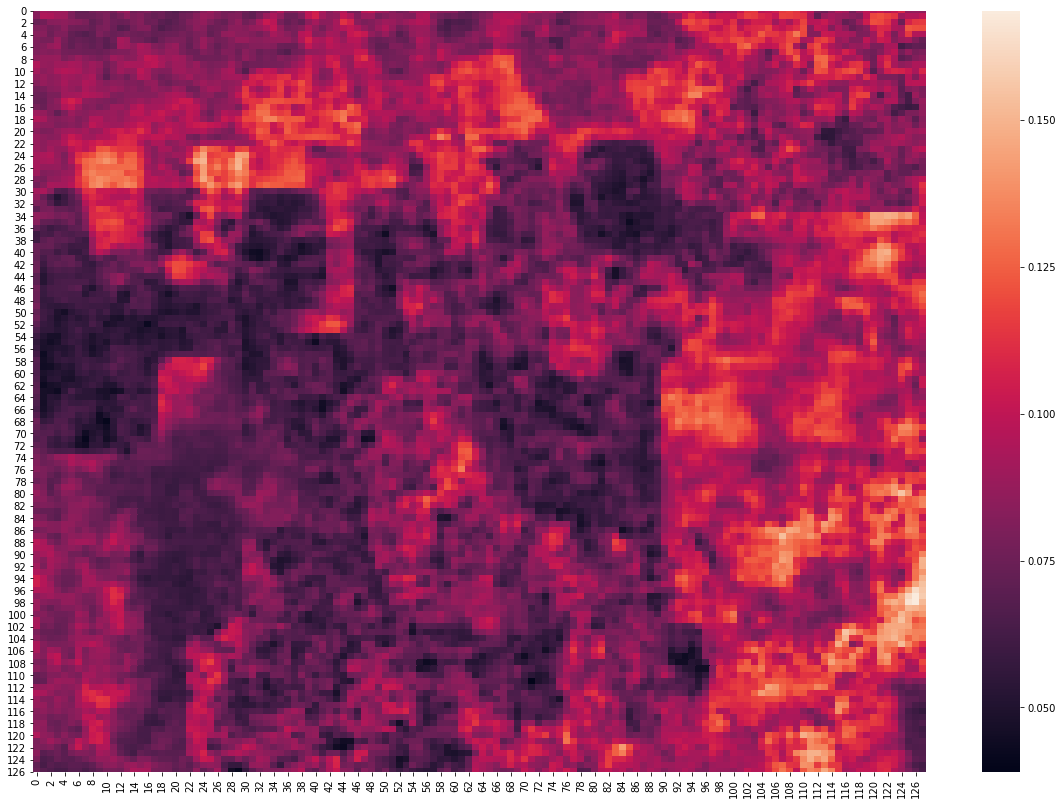

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 14))
sns.heatmap(x2[1][27, :, :, 0]) # 22, 27, 29, 

In [15]:
import logging
START_Y = 0
START_X = 0

import multiprocessing
for i in corner_coordinates[:8]:
    try:
        threads = 3
        pool = multiprocessing.Pool(threads)
        zip(*pool.map(worker_download, i[:12]))
        pool.close()
        pool.join()
    except Exception as e:
        print("error")
        logging.fatal(e, exc_info=True)

Starting: 1 0
Starting: 0 0
Starting: 2 0
[]
[]
1
[]
0
2
Original size: (135, 128, 128, 6)
Original size: (135, 128, 128, 6)
Original size: (135, 128, 128, 6)
Original 10 size: (135, 128, 128, 5)
Data shape: (135, 128, 128)
Downloaded imagery
There are 35/135 dirty steps: 32 cloud, 15 missing, 5 shadows
Removing 0 steps based on ratio
Original 10 size: (135, 128, 128, 5)
Original 10 size: (135, 128, 128, 5)
Data shape: (135, 128, 128)
Downloaded imagery
There are 28/135 dirty steps: 26 cloud, 10 missing, 1 shadows
Data shape: (135, 128, 128)
Downloaded imagery
There are 30/135 dirty steps: 28 cloud, 8 missing, 1 shadows
Removing 1 steps based on ratio
Removing 1 steps based on ratio
Removed 242970.53125 fake shadows, leaving 17795.693359375
The total percent shadow cover is: 0.010861629247665405%
Removed 511040.0 fake shadows, leaving 23104.0
The total percent shadow cover is: 0.013303360849056603%
Removed 9088.0 fake shadows, leaving 5376.0
The total percent shadow cover is: 0.0031550

KeyboardInterrupt: 